In [38]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import svm

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv("all_data.csv", encoding='utf-8')

### PCA Analysis

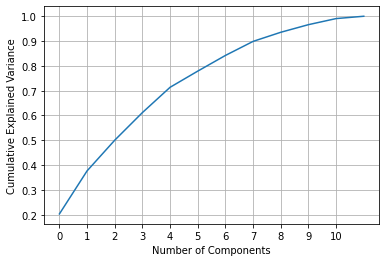

In [10]:
# Select columns to run pca with
X = df[[ 'education',  'state_legislature',
       'governor', 'lt_governor', 'labour_force_participation',
       'mngmt_job_wage_gap', 'bachelor_wage_gap', 'ab_legality',
       'life_exp_f_m', 'sex_ratio_birth', 'abortion_rate', 'year'
       ]]
y = df['rape_rate']  
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Build PCA model
pca = PCA().fit(X)

# Plot PCA curve
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(0, 11, 1))
plt.grid()
plt.show()

Thus, we choose cumulative explained variance (CEV) = 0.9 as the cutoff. When CEV is 0.9, PCA shows the number of component 7, which means 90% of the total variance in the dataset is explained by the retained principal components. 

##### Train Test Split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Linear Regression

##### Linear Regression without PCA

In [41]:
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Model accuracy
print('r2: ', model.score(X_test,y_test))

r2:  0.4705402909334574


##### Linear Regression with PCA

In [36]:
model = Pipeline(steps=[('pca', PCA(n_components=7)),
                        ('regression', LinearRegression())])
model.fit(X_train, y_train)
r2 = model.score(X_test, y_test)
print('r2: ', r2)
n = len(y_test)
k = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print('adjusted_r2: ', adj_r2)

r2:  0.4272743446240099
adjusted_r2:  0.37710859378815675


Linear regression with PCA performs better than linear regression without PCA

#### Random Forest Regressor

In [44]:
model = RandomForestRegressor(n_estimators=500, max_depth=10)
model.fit(X_train, y_train)
model.score(X_test, y_test)
r2 = model.score(X_test, y_test)
print('r2: ', r2)
n = len(y_test)
k = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print('adjusted_r2: ', adj_r2) 

# Cross validation
cv_scores = cross_val_score(model, X, y, cv=5)
print('Cross-Validation scores:', cv_scores)
print('Mean score:', cv_scores.mean())

r2:  0.7683625567804206
adjusted_r2:  0.7480731456954939
Cross-Validation scores: [ 0.77341681  0.79691329  0.84001334  0.87320534 -0.2298974 ]
Mean score: 0.610730278616437


### Ridge Regression

In [31]:
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
r2 = model.score(X_test, y_test)
print('r2: ', r2)
n = len(y_test)
k = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print('adjusted_r2: ', adj_r2)

r2:  0.4712800018260278
adjusted_r2:  0.42496876111005943


### Lasso Regression

In [32]:
model = Lasso(alpha=0)
model.fit(X_train, y_train)
r2 = model.score(X_test, y_test)
print('r2: ', r2)
n = len(y_test)
k = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print('adjusted_r2: ', adj_r2)

r2:  0.47054029093345706
adjusted_r2:  0.424164258022519


C:\Users\18973\AppData\Local\Temp\ipykernel_11260\3888975243.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train, y_train)
c:\Users\18973\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\18973\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.035e+04, tolerance: 1.141e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


### SVM Regression

In [29]:
model = svm.SVR(kernel='poly', degree=3, C=1)
model.fit(X_train, y_train)
r2 = model.score(X_test, y_test)
print('r2: ', r2)
n = len(y_test)
k = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print('adjusted_r2: ', adj_r2)

r2:  0.38056396585762786
adjusted_r2:  0.3263067949838434
